In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("test.csv")
train.head()

,Unnamed: 0,category,amt,city_pop,dob,is_fraud,time,month,weekday,Llat,Llong
0,0,misc_net,4.97,3495,37,0,0,1,1,0.067507,0.870215
1,1,grocery_pos,107.23,149,47,0,0,1,1,0.271247,0.024038
2,2,entertainment,220.11,4154,63,0,0,1,1,0.969904,0.107519
3,3,gas_transport,45.00,1939,58,0,0,1,1,0.803731,0.447271
4,4,misc_pos,41.96,99,39,0,0,1,1,0.254299,0.830441


In [3]:
train.drop("Unnamed: 0", axis=1, inplace=True)
train = train[train['amt'] <= 2500]
train.head()

,category,amt,city_pop,dob,is_fraud,time,month,weekday,Llat,Llong
0,misc_net,4.97,3495,37,0,0,1,1,0.067507,0.870215
1,grocery_pos,107.23,149,47,0,0,1,1,0.271247,0.024038
2,entertainment,220.11,4154,63,0,0,1,1,0.969904,0.107519
3,gas_transport,45.00,1939,58,0,0,1,1,0.803731,0.447271
4,misc_pos,41.96,99,39,0,0,1,1,0.254299,0.830441


In [4]:
# from joblib import dump
# # 计算每个类别的目标均值
# target_encoding = train.groupby('category')['is_fraud'].mean()

# # 保存 target_encoding
# dump(target_encoding, '../finance-server/uploads/target_encoding.joblib')

# # 将目标均值映射到原始数据
# train['Encoding'] = train['category'].map(target_encoding)
# train.head()

import pandas as pd
# One-Hot 编码
train = pd.get_dummies(train, columns=['category'], drop_first=True)

# 动态获取 One-Hot 编码后的列名
one_hot_columns = [col for col in train.columns if col.startswith('category_')]

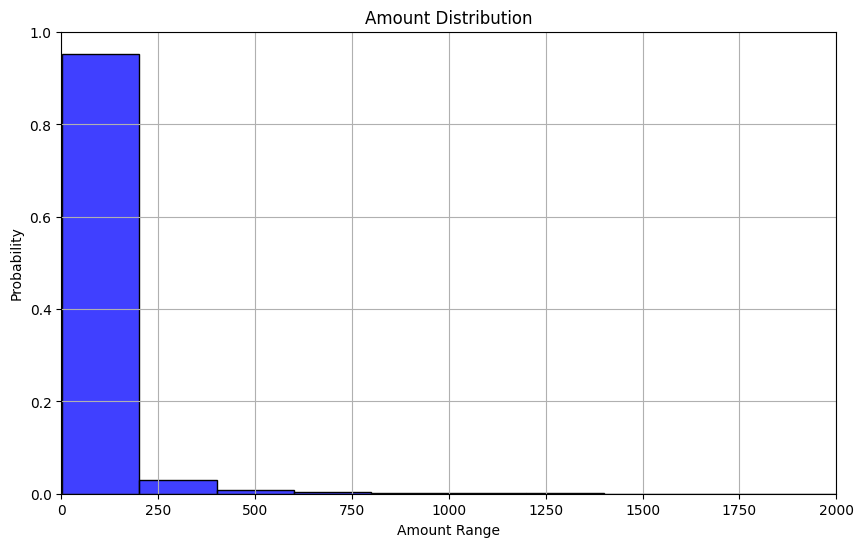

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# 提取 'amt' 列
amt_column = train['amt']
amt_filtered = amt_column[(amt_column >= 0) & (amt_column <= 2000)]
# 绘制直方图

plt.figure(figsize=(10, 6))  # 设置图形大小
sns.histplot(amt_filtered , bins=10, kde=False, color='blue', stat='probability')  # 使用 seaborn 绘制直方图
plt.title('Amount Distribution')  # 设置标题
plt.xlabel('Amount Range')  # 设置 x 轴标签
plt.ylabel('Probability')  # 设置 y 轴标签
plt.xlim(0, 2000)  # 将 x 轴范围设置为 0 到 10000
plt.grid(True)  # 添加网格
plt.show()  # 显示图形

In [6]:
train['amt'].describe()


count    1.296188e+06
mean     6.853519e+01
std      1.110408e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.749000e+01
75%      8.308000e+01
max      2.498050e+03
Name: amt, dtype: float64

<Axes: xlabel='Llat'>

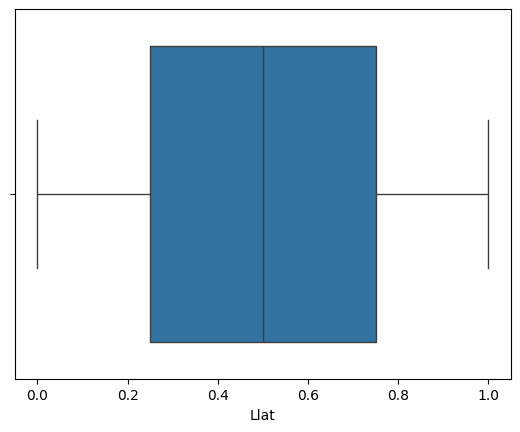

In [7]:
sns.boxplot(x=train['Llat'])


<Axes: xlabel='Llong'>

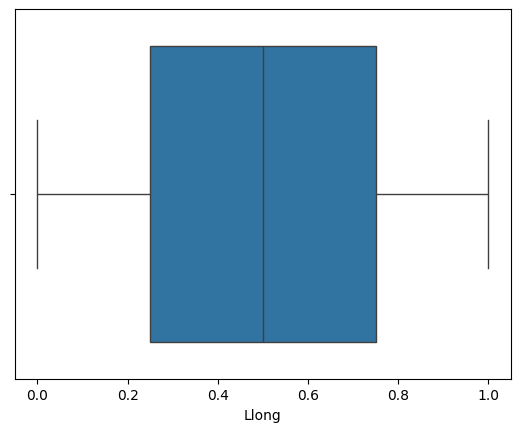

In [8]:
sns.boxplot(x=train['Llong'])


<Axes: xlabel='city_pop'>

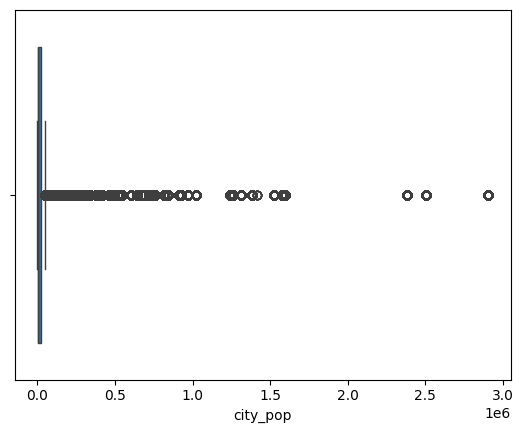

In [9]:
sns.boxplot(x=train['city_pop'])

In [10]:
# selected_features = ['amt','city_pop','dob','time','weekday','Llat','Encoding']
selected_features = ['amt','city_pop','dob','time','weekday','Llat']+ one_hot_columns
X = train[selected_features]  # 选择特定特征
y = train['is_fraud']  # 目标变量

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# from imblearn.combine import SMOTETomek

# smote_tomek = SMOTETomek(random_state=42)
# x_train_resampled,y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 加载保存的 CSV 文件
resampled_data = pd.read_csv("resampled_data.csv")
# 分离特征和目标
x_train_resampled = resampled_data.drop(columns=["is_fraud"])
y_train_resampled = resampled_data["is_fraud"]

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# # 初始化随机森林模型
# model = RandomForestClassifier(
#     n_estimators=40,  # 树的数量
#     criterion='gini',  # 分裂标准（基尼系数）
#     max_depth=25,  # 树的最大深度
#     class_weight='balanced',  # 自动调整类别权重
#     random_state=42,
#     verbose=1,  # 显示训练过程
#     n_jobs = 3,
#     min_samples_split = 150,
#     min_samples_leaf = 50
# )

# 初始化随机森林模型
model = RandomForestClassifier(
    n_estimators=300,  # 树的数量
    criterion='gini',  # 分裂标准（基尼系数）
    max_depth=None,  # 树的最大深度
    class_weight=None,  # 自动调整类别权重
    random_state=42,
    verbose=1,  # 显示训练过程
    n_jobs = 3,
    min_samples_split = 2,
    min_samples_leaf = 1
)

# 训练模型
model.fit(x_train_resampled, y_train_resampled)
# 训练模型
# model.fit(x_train_resampled, y_train_resampled, eval_set=[(X_test, y_test)], verbose=True)

# 预测
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  9.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    3.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.3s


AUC: 0.9926783560531188


[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    3.5s finished


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


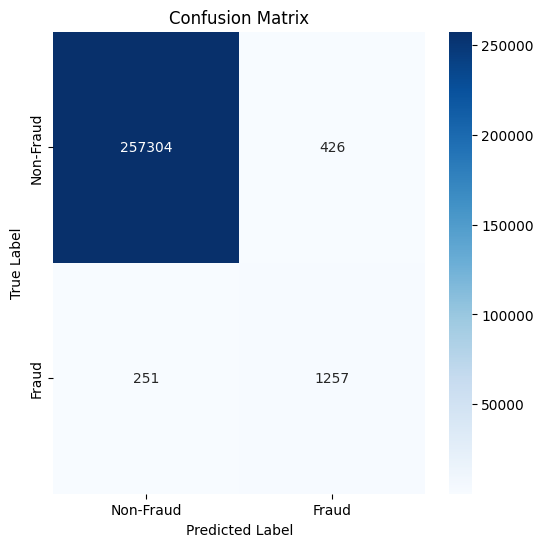

In [15]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


AUC Score: 0.9927


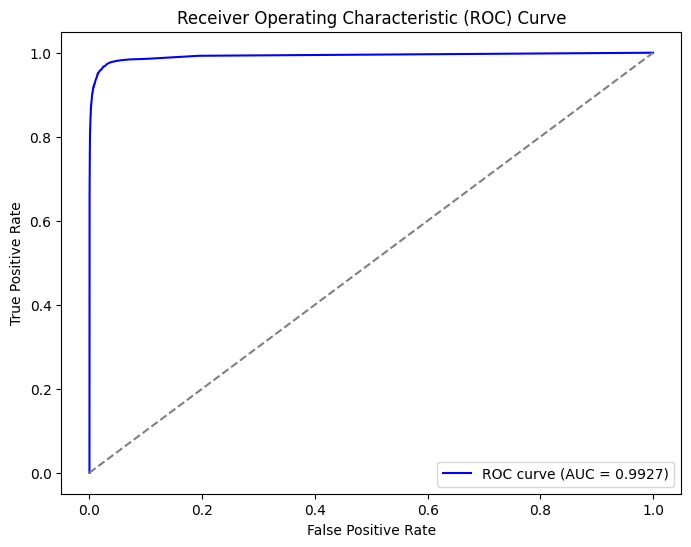

In [16]:
# 计算 AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# 计算 ROC 曲线的 FPR 和 TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("../finance-web/public/XGBoostROC.png")  # 保存为文件
plt.show()


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.7469
Recall: 0.8336
F1-Score: 0.7878


In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9974


In [19]:

    # 计算评估指标
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# 假设 y_test 是真实标签，y_pred 是预测标签，y_prob 是预测概率
auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 创建 DataFrame
results = pd.DataFrame({
    'AUC': [f"{auc:.4f}"],  # 格式化 AUC
    'Precision': [f"{precision:.4f}"],  # 格式化 Precision
    'Recall': [f"{recall:.4f}"],  # 格式化 Recall
    'F1Score': [f"{f1:.4f}"]  # 格式化 F1Score
})
    results.to_csv("../finance-server/uploads/Random.csv", index=False)  # 保存为 CSV 文件

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    257730
       Fraud       0.75      0.83      0.79      1508

    accuracy                           1.00    259238
   macro avg       0.87      0.92      0.89    259238
weighted avg       1.00      1.00      1.00    259238

AUC Score: 0.9927
Precision: 0.7469
Recall: 0.8336
F1-Score: 0.7878


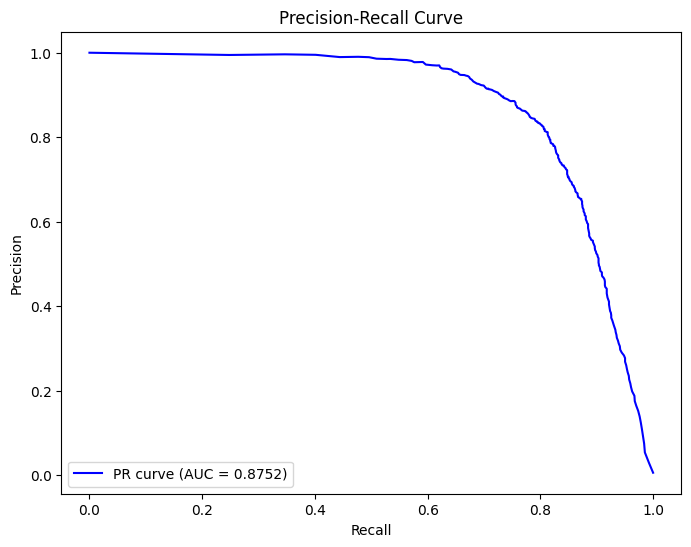

In [20]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [21]:
random_sample = train.sample(n=5, random_state=42)  # random_state 确保结果可复现
selected_features = ['amt','city_pop','dob','time','weekday','Llat']+ one_hot_columns
X1 = random_sample[selected_features]  # 选择特定特征
predictions =model.predict(X1)
predictions2 = model.predict_proba(X1)[:, 1]
# 输出预测结果
print("Predictions:", predictions)
print("predictions2:", predictions2)
print("is_fraud:", random_sample['is_fraud'])

Predictions: [0 0 0 0 0]
predictions2: [0. 0. 0. 0. 0.]
is_fraud: 5913       0
312966     0
17736      0
1161788    0
240860     0
Name: is_fraud, dtype: int64


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.0s finished


In [22]:
newTest = pd.read_csv("Newtest.csv")
newX = newTest[selected_features]
newY = newTest['is_fraud']
new_pred = model.predict(newX)
new_prob = model.predict_proba(newX)[:, 1]  # 预测概率（用于 AUC 和 ROC）

# 假设 y_test 是真实标签，y_pred 是预测标签，y_prob 是预测概率
print(f"AUC Score: {roc_auc_score(newY, new_prob):.4f}")
print(f"Precision: {precision_score(newY, new_pred):.4f}")
print(f"Recall: {recall_score(newY, new_pred):.4f}")
print(f"F1-Score: {f1_score(newY, new_pred):.4f}")

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    6.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s


AUC Score: 0.9920
Precision: 0.6866
Recall: 0.8182
F1-Score: 0.7466


[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    6.5s finished


In [23]:
from joblib import dump

# 假设 best_model 是训练好的模型
# dump(model, '../finance-server/uploads/XGBoostModel.joblib')